In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import optuna
from optuna.samplers import TPESampler
import sqlite3
from datetime import datetime

# display all of the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns',None)

%matplotlib inline

In [24]:
# Path to mock database
SQL_PATH = 'data/MockDatabase.db'

# Path to model storage location
MODEL_STORAGE_PATH = 'models/'

In [25]:
# Code in the following cells was adapted from: https://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return conn

### Data analysis

In [26]:
# Read in training data
conn = create_connection(SQL_PATH)

read_query = '''SELECT Age, Sex, ChestPainType, RestingBP, Cholesterol, 
              FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease
              FROM heart'''

data_train = pd.read_sql(read_query, conn)
conn.close()

print(data_train.shape)
data_train.head()

(2754, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [27]:
data_train['Oldpeak'].describe()

count    2754.000000
mean        0.887364
std         1.066183
min        -2.600000
25%         0.000000
50%         0.600000
75%         1.500000
max         6.200000
Name: Oldpeak, dtype: float64

In [28]:
# How much data is missing
data_train.isna().sum() / len(data_train) # This will output the proportion of missing values in each column

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

In [29]:
import numpy as np

# Separate columns by data type for analysis
cat_cols = [col for col in data_train.columns if data_train[col].dtype == object]
num_cols = [col for col in data_train.columns if data_train[col].dtype != object]
assert len(cat_cols) + len(num_cols) == data_train.shape[1]


Text(0.5, 1.0, 'Feature Cardinality')

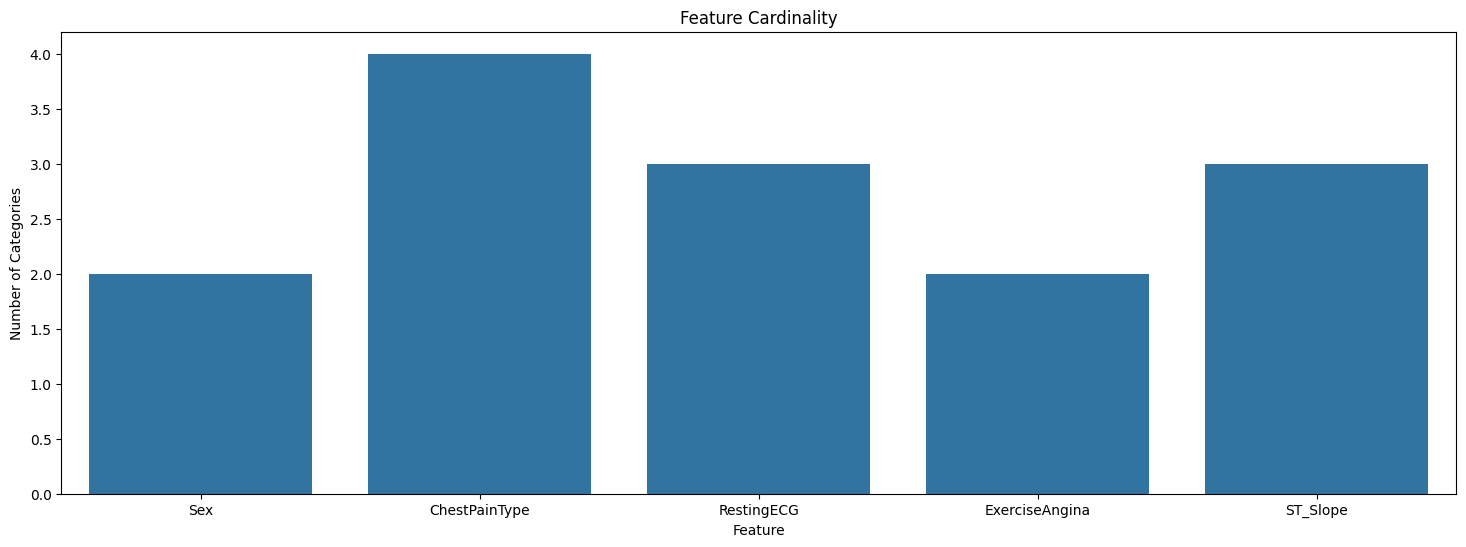

In [30]:
# Look at cadinality of the categorical columns
cards = [len(data_train[col].unique()) for col in cat_cols]

fig,ax = plt.subplots(figsize=(18,6))
sns.barplot(x=cat_cols, y=cards)
ax.set_xlabel('Feature')
ax.set_ylabel('Number of Categories')
ax.set_title('Feature Cardinality')

Sex
M    0.78976
F    0.21024
Name: count, dtype: float64


Text(0.5, 1.0, 'Number of patients by sex')

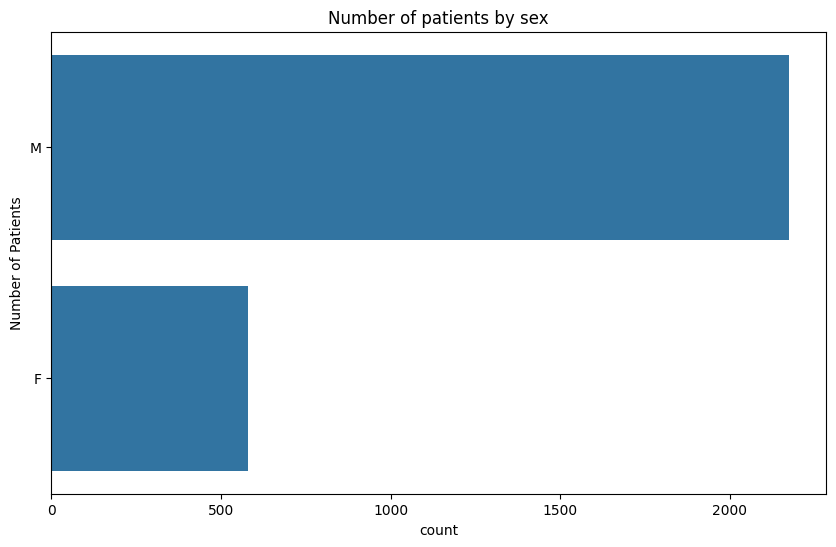

In [31]:
# Distribution of categorical variables
fig,ax = plt.subplots(figsize=(10,6))
print(data_train['Sex'].value_counts() / len(data_train))
sns.countplot(data_train['Sex'])
ax.set_ylabel('Number of Patients')
ax.set_title('Number of patients by sex')

Sex
M    0.901575
F    0.098425
Name: count, dtype: float64


Text(0.5, 1.0, 'Number of patients with heart disease by sex')

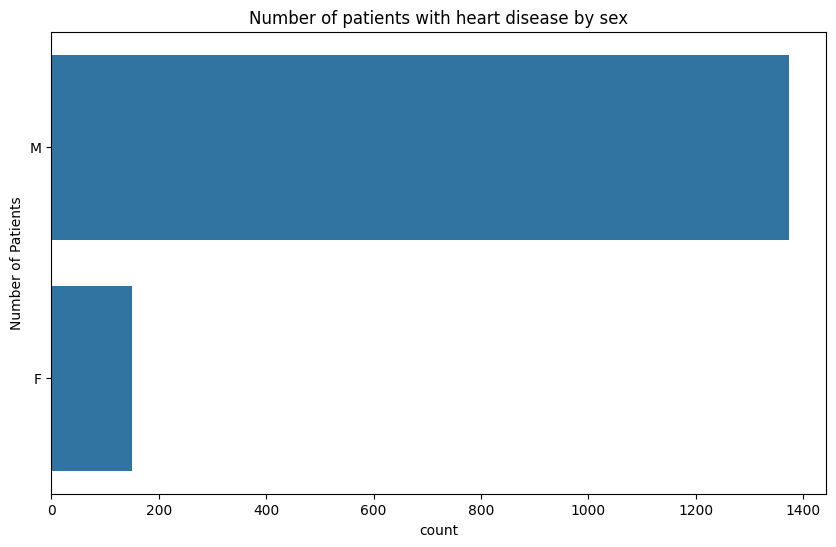

In [32]:
# Distribution of categorical variables
fig,ax = plt.subplots(figsize=(10,6))
data_train_disease = data_train[data_train['HeartDisease']==1].sort_values('Sex', ascending=False)

print(data_train_disease['Sex'].value_counts() / len(data_train_disease))

sns.countplot(data_train_disease['Sex'])
ax.set_ylabel('Number of Patients')
ax.set_title('Number of patients with heart disease by sex')

In [33]:
# Distribution of cholesterol by disease status
fig,ax = plt.subplots(figsize=(10,6))
data_train_disease = data_train[data_train['HeartDisease']==1]
data_train_no_disease = data_train[data_train['HeartDisease']==0]

sns.distplot(data_train_no_disease['Cholesterol'], label='No disease')
sns.distplot(data_train_disease['Cholesterol'], label='Disease')
ax.legend()
ax.set_title('Cholesterol Distribution')

C:\Users\PC-ACER\AppData\Local\Temp\ipykernel_19628\1267758695.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_train_no_disease['Cholesterol'], label='No disease')
C:\Users\PC-ACER\AppData\Local\Temp\ipykernel_19628\1267758695.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_tra

Text(0.5, 1.0, 'Cholesterol Distribution')

Error in callback <function flush_figures at 0x000001E8CE0DEE80> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

C:\Users\PC-ACER\AppData\Local\Temp\ipykernel_19628\3530682286.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_train_no_disease['RestingBP'], label='No disease')
C:\Users\PC-ACER\AppData\Local\Temp\ipykernel_19628\3530682286.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_train

Text(0.5, 1.0, 'Resting BP Distribution')

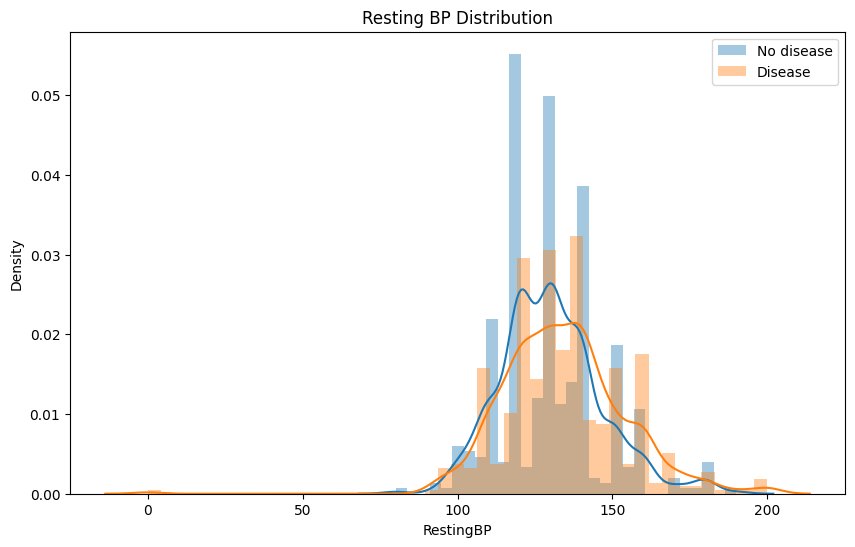

In [ ]:
# Distribution of bp by disease status
fig,ax = plt.subplots(figsize=(10,6))
data_train_disease = data_train[data_train['HeartDisease']==1]
data_train_no_disease = data_train[data_train['HeartDisease']==0]

sns.distplot(data_train_no_disease['RestingBP'], label='No disease')
sns.distplot(data_train_disease['RestingBP'], label='Disease')
ax.legend()
ax.set_title('Resting BP Distribution')

HeartDisease
1    0.553377
0    0.446623
Name: count, dtype: float64


Text(0.5, 1.0, 'Heart Disease Distribution')

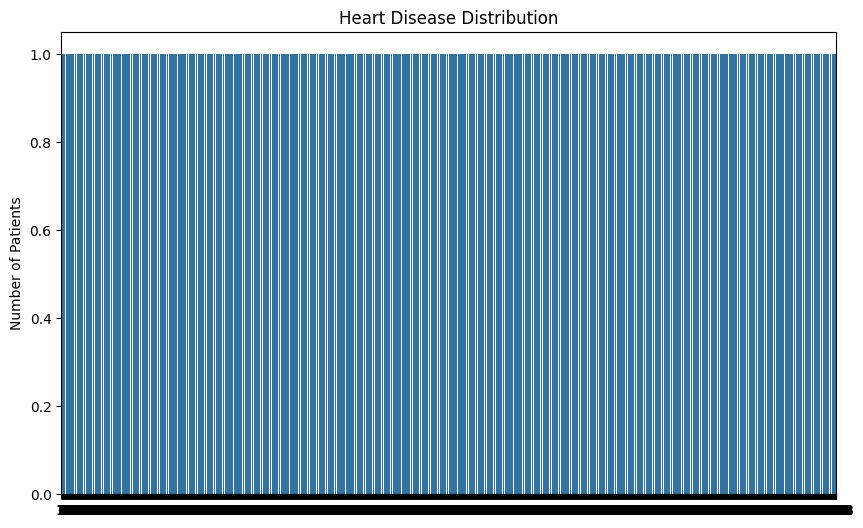

In [ ]:
# Target distribution
fig,ax = plt.subplots(figsize=(10,6))
print(data_train['HeartDisease'].value_counts() / len(data_train))
sns.countplot(data_train['HeartDisease'])
ax.set_ylabel('Number of Patients')
ax.set_title('Heart Disease Distribution')

### Preprocessing

In [ ]:
# Convert missing values to string
data_train.replace(np.nan,'NaN',inplace=True)
data_train.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [ ]:
# Create training and testing data
x, y = data_train.dropna().drop(['HeartDisease'], axis=1), data_train.dropna()['HeartDisease']
    
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

print(x_train.shape)
print(x_test.shape)
x_train.head()

(2203, 11)
(551, 11)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
1326,59,M,ASY,110,0,1,Normal,94,N,0.0,Flat
2377,76,M,NAP,104,113,0,LVH,120,N,3.5,Down
1605,70,M,ATA,156,245,0,LVH,143,N,0.0,Up
144,56,F,ATA,120,279,0,Normal,150,N,1.0,Flat
721,51,M,NAP,100,222,0,Normal,143,Y,1.2,Flat


### Initial model training

In [ ]:
# Specify index of categorical features in input data
cat_features = [x.columns.get_loc(col) for col in cat_cols]

# Model parameter dict
params = {'iterations':5000,
          'loss_function':'Logloss',
          'depth':4,
          'early_stopping_rounds':20,
          'custom_loss':['AUC', 'Accuracy']}

# Instantiate model
model = CatBoostClassifier(**params)

# Fit model
model.fit(
    x_train,
    y_train,
    cat_features=cat_features,
    eval_set=(x_test, y_test),
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.019124
0:	learn: 0.6777119	test: 0.6779085	best: 0.6779085 (0)	total: 186ms	remaining: 15m 28s
50:	learn: 0.3644053	test: 0.3600836	best: 0.3600836 (50)	total: 2.09s	remaining: 3m 22s
100:	learn: 0.3042850	test: 0.3022592	best: 0.3022592 (100)	total: 3.93s	remaining: 3m 10s
150:	learn: 0.2754369	test: 0.2796145	best: 0.2796145 (150)	total: 5.69s	remaining: 3m 2s
200:	learn: 0.2573893	test: 0.2684365	best: 0.2684365 (200)	total: 7.64s	remaining: 3m 2s
250:	learn: 0.2431550	test: 0.2575535	best: 0.2575535 (250)	total: 9.69s	remaining: 3m 3s
300:	learn: 0.2323310	test: 0.2511239	best: 0.2511239 (300)	total: 11.8s	remaining: 3m 3s
350:	learn: 0.2226535	test: 0.2467241	best: 0.2467241 (350)	total: 13.8s	remaining: 3m 2s
400:	learn: 0.2131313	test: 0.2407035	best: 0.2407035 (400)	total: 16s	remaining: 3m 3s
450:	learn: 0.2032320	test: 0.2338989	best: 0.2338989 (450)	total: 18.2s	remaining: 3m 3s
500:	learn: 0.1925261	test: 0.2260583	best: 0.2260583 (500)	total: 20.3s	r

In [ ]:
model


In [ ]:
# Make predictions on test data
preds = model.predict(x_test)

In [ ]:
# Evaluate predictions
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       256
           1       0.99      0.99      0.99       295

    accuracy                           0.99       551
   macro avg       0.99      0.99      0.99       551
weighted avg       0.99      0.99      0.99       551

[[253   3]
 [  2 293]]


<Axes: xlabel='importance', ylabel='feature'>

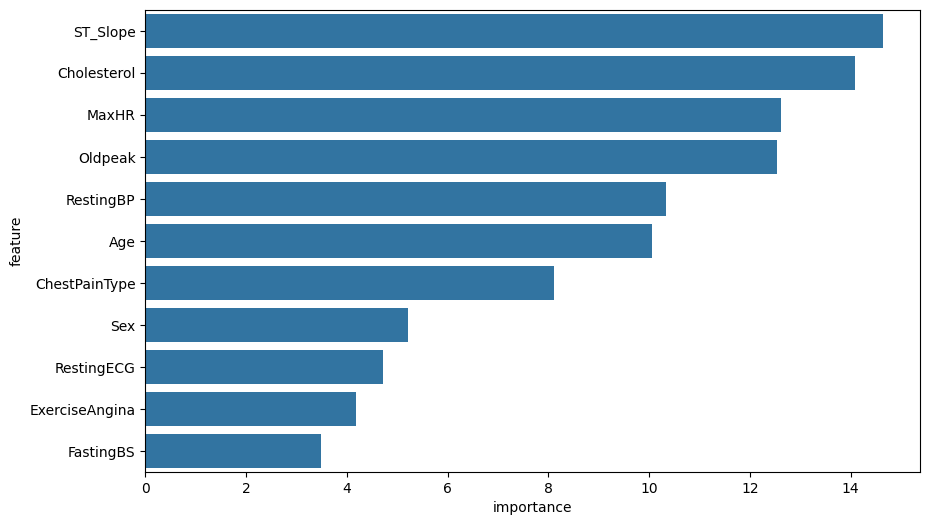

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
feature_importance_data = pd.DataFrame({'feature':model.feature_names_, 'importance':model.feature_importances_})
feature_importance_data.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x='importance', y='feature', data=feature_importance_data)

### Hyperparameter tuning

In [ ]:
def classification_objective(trial):

    params = {
        "loss_function":"Logloss",
        'custom_loss':['Accuracy'],
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20)}
    
    if params["bootstrap_type"] == "Bayesian":
        
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
    elif params["bootstrap_type"] == "Bernoulli":
        
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_data = cv(
    params = params,
    pool = Pool(x, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=False,
    verbose=False)
    
    return cv_data['test-Accuracy-mean'].values[-1]

In [ ]:
classification_study = optuna.create_study(sampler=TPESampler(), direction="maximize")
classification_study.optimize(classification_objective, n_trials=20, timeout=600) 
trial = classification_study.best_trial

print(f"Highest Accuracy: {trial.value}")
print("Optimal Parameters:")
for key, val in trial.params.items():
    print(f"{key}:{val}")

[I 2024-04-21 11:27:53,430] A new study created in memory with name: no-name-d0f16326-6c5d-4bf9-a686-0f9b3ad7106b
C:\Users\PC-ACER\AppData\Local\Temp\ipykernel_19628\2942389915.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),


Training on fold [0/5]

bestTest = 0.04427815628
bestIteration = 999

Training on fold [1/5]

bestTest = 0.05595438005
bestIteration = 994

Training on fold [2/5]

bestTest = 0.04259878824
bestIteration = 999

Training on fold [3/5]

bestTest = 0.04620336292
bestIteration = 999

Training on fold [4/5]


[I 2024-04-21 11:28:26,040] Trial 0 finished with value: 0.9876522026068306 and parameters: {'l2_leaf_reg': 0.012345733195204898, 'colsample_bylevel': 0.14327730688957369, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 15, 'subsample': 0.9617071266005106}. Best is trial 0 with value: 0.9876522026068306.



bestTest = 0.07812274999
bestIteration = 999

Training on fold [0/5]

bestTest = 0.03802252931
bestIteration = 999

Training on fold [1/5]

bestTest = 0.04048590398
bestIteration = 999

Training on fold [2/5]

bestTest = 0.04196367333
bestIteration = 999

Training on fold [3/5]

bestTest = 0.0435172132
bestIteration = 999

Training on fold [4/5]


[I 2024-04-21 11:33:53,149] Trial 1 finished with value: 0.9920072595281306 and parameters: {'l2_leaf_reg': 0.29071384964954655, 'colsample_bylevel': 0.753101095309908, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 12, 'one_hot_max_size': 16, 'bagging_temperature': 6.808791050744692}. Best is trial 1 with value: 0.9920072595281306.



bestTest = 0.08068486282
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3573507467
bestIteration = 999

Training on fold [1/5]

bestTest = 0.3391552791
bestIteration = 995

Training on fold [2/5]

bestTest = 0.3651772979
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3672319884
bestIteration = 999

Training on fold [4/5]


[I 2024-04-21 11:34:02,130] Trial 2 finished with value: 0.8703672661277018 and parameters: {'l2_leaf_reg': 0.07511979283894323, 'colsample_bylevel': 0.019629807553048495, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 7, 'one_hot_max_size': 12, 'subsample': 0.5310236966483702}. Best is trial 1 with value: 0.9920072595281306.



bestTest = 0.3593543063
bestIteration = 991

Training on fold [0/5]

bestTest = 0.002310577707
bestIteration = 992

Training on fold [1/5]


[W 2024-04-21 11:34:56,653] Trial 3 failed with parameters: {'l2_leaf_reg': 0.055055928626324656, 'colsample_bylevel': 0.6145157774248313, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 3, 'bagging_temperature': 6.136773920335834} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\PC-ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\PC-ACER\AppData\Local\Temp\ipykernel_19628\2942389915.py", line 22, in classification_objective
    cv_data = cv(
              ^^^
  File "c:\Users\PC-ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\catboost\core.py", line 6924, in cv
    return _cv(
           ^^^^
  File "_catboost.pyx", line 5696, in _catboost._cv
  File "_catboost.pyx", line 5728, in _catboost._cv
Keyboard

KeyboardInterrupt: 

In [ ]:
trial.params

### Fit final model using new parameters

In [ ]:
new_params = trial.params.copy()
new_params['loss_function'] = 'Logloss'
new_params['custom_loss'] = ['AUC','Accuracy']

cv_data = cv(
        params = new_params,
        pool = Pool(x, label=y, cat_features=cat_features),
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        plot=False,
        stratified=False,
        verbose=False)

cv_data

In [ ]:
final_params = new_params.copy()
final_params['iterations'] = np.argmax(cv_data['test-Accuracy-mean'])
final_params['cat_features'] = cat_features

final_model = CatBoostClassifier(**final_params)
final_model.fit(x,y,verbose=100)

In [ ]:
# Export model
model_name = f'heart_disease_model_{str(datetime.today())[0:10]}'
final_model.save_model(MODEL_STORAGE_PATH + model_name)

In [ ]:
CatBoostClassifier().load_model(MODEL_STORAGE_PATH + 'heart_disease_model_2021-12-28').feature_names_